In [7]:
import numpyro
numpyro.enable_x64()
# numpyro.set_platform('gpu')

import jax
print(jax.devices())

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value, init_to_sample, Trace_ELBO, TraceGraph_ELBO

from numpyro.infer.svi import SVI
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoLaplaceApproximation, AutoDAIS, AutoBNAFNormal, AutoIAFNormal, AutoMultivariateNormal
from numpyro.optim import Adam, ClippedAdam

import tensorflow_probability.substrates.jax as tfp

from jax import numpy as jnp
from jax import random, vmap

import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns

import siuba as s
from siuba import _

from plotnine import *

from matplotlib import pyplot as plt

import pickle

from lib.helpers import *
from lib.models import *

[GpuDevice(id=0, process_index=0)]


In [31]:
## Define functions

def fit_svi(model, x_data, y_data, optimizer=Adam(1e-3), loss=TraceGraph_ELBO(), n_steps=10_000, full_rank = False, filename=None, **kwargs):
    if full_rank:
        guide = AutoMultivariateNormal(model, **kwargs)
    else:
        guide = AutoNormal(model, **kwargs)

    if filename is not None and os.path.exists(filename):
        result = pickle.load(open(filename, "rb"))
        return result
    else:
        svi = SVI(model, guide, optimizer, loss)
        result = svi.run(random.PRNGKey(1), n_steps, x_data, y_data)
        output = {"params": result.params, "guide": guide, "losses": result.losses}

        if filename is not None:
            pickle.dump(output, open(filename, "wb"))

        return(output)


def arviz_from_svi(model, guide, params, *args, obs_data=None, num_samples = 1_000, filename=None):
    
    if filename is not None and os.path.exists(filename):
        result = pickle.load(open(filename, "rb"))
        return result
    
    else:
        
        posterior_samples = guide.sample_posterior(random.PRNGKey(1), params=params, sample_shape=(num_samples,))
        samples_posterior_predictive = Predictive(model=model, posterior_samples=posterior_samples)(random.PRNGKey(1), *args)
        samples_prior_predictive = Predictive(model=model, params=None, num_samples=num_samples)(random.PRNGKey(2), *args)

        ll_dict = numpyro.infer.util.log_likelihood(model, posterior_samples, *args, obs_data)
        data = {}
        for obs_name, log_like in ll_dict.items(): # don't think this is necessary but just to be safe ...
            shape = (1, len(log_like)) + log_like.shape[1:]
            data[obs_name] = np.reshape(log_like.copy(), shape)

        result = az.from_dict(
            {k: np.expand_dims(v, 0) for k, v in posterior_samples.items()},
            prior = {k: np.expand_dims(v, 0) for k, v in samples_prior_predictive.items()},
            posterior_predictive = {k: np.expand_dims(v, 0) for k, v in samples_posterior_predictive.items()},
            log_likelihood = data,
            observed_data = {"yhat": obs_data}
        )
        
        if filename is not None:
            pickle.dump(result, open(filename, "wb"))
        
        return(result)
        

In [3]:
## Load Experiment 1 data
df1 = load_data_exp1() 
df1 = df1[~df1.querytype.str.contains('or')] # filtering as in avg analyses
df1 = (df1 >>
    s.arrange(_.ID) >>
    s.mutate(block = _.block-1) >> 
      s.mutate(estimate =  np.round(_.estimate*20).astype("int64"))
)

X_exp1, y_exp1 = make_model_data(df1)
print(len(y_exp1), "observations")


5664 observations


<AxesSubplot:xlabel='estimate'>

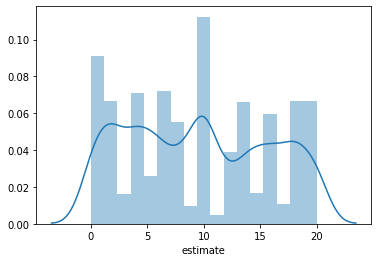

In [4]:
sns.distplot(df1.estimate)

In [5]:
## Load Experiment 2 data

df2 = (load_data_exp2_trials()  >> 
        s.filter(_.condition!=2) >>
      s.mutate(block = _.block-1) >> 
      s.mutate(estimate =  np.round(_.estimate*20).astype("int64"))
     )

X_exp2, y_exp2 = make_model_data(df2)
print(len(y_exp2), "observations")

10080 observations


<AxesSubplot:xlabel='estimate'>

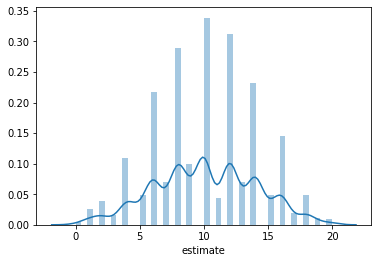

In [6]:
sns.distplot(df2.estimate)

## Experiment 1 - Bayesian Sampler

In [38]:
res_bs_exp1 = fit_svi(
    bs_complex_mlm_trial_level, 
    X_exp1, 
    y_exp1,
    optimizer = ClippedAdam(2.5e-4, clip_norm=1., b1=.95), # very finnicky
    loss = TraceGraph_ELBO(num_particles=4), # refit
    n_steps = 20_000, 
    full_rank=True,
    filename="local/svi-bs_complex_mlm_trial_level-exp1.p"
)

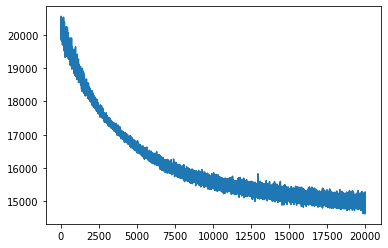

In [39]:
from matplotlib import pyplot as plt
plt.plot(res_bs_exp1["losses"])

In [40]:
az_bs_exp1 = arviz_from_svi(
    bs_complex_mlm_trial_level, 
    res_bs_exp1["guide"], 
    res_bs_exp1["params"], 
    X_exp1, 
    obs_data=y_exp1,
    filename = "local/az-bs_complex_mlm_trial_level-exp1svi.p"
)

<AxesSubplot:xlabel='yhat / yhat'>

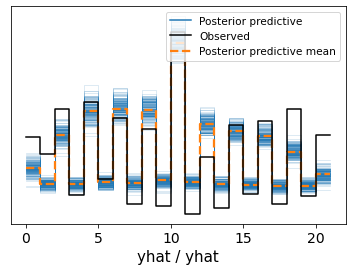

In [16]:
az.plot_ppc(az_bs_exp1, num_pp_samples=200)

In [17]:
az_bs_exp1.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.47484208, 0.08719072, 0.4379672 ]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

## Experiment 1 - PT+N

In [8]:
res_ptn_exp1 = fit_svi(
    ptn_simplecond_mlm_trial_level_disc, 
    X_exp1, 
    y_exp1,
    optimizer = Adam(1e-3),
    n_steps = 10_000,
    full_rank=True,
    filename="local/svi-ptn_simplecond_mlm_trial_level_disc-exp1.p"
)

100%|██████████| 10000/10000 [23:26<00:00,  7.11it/s, init loss: 19214.4038, avg. loss [9501-10000]: 12984.1924]


In [33]:
az_ptn_exp1 = arviz_from_svi(
    ptn_simplecond_mlm_trial_level_disc, 
    res_ptn_exp1["guide"], 
    res_ptn_exp1["params"], 
    X_exp1, 
    obs_data=y_exp1,
    filename = "local/az-ptn_simplecond_mlm_trial_level_disc-exp1svi.p"
)

<AxesSubplot:xlabel='yhat / yhat'>

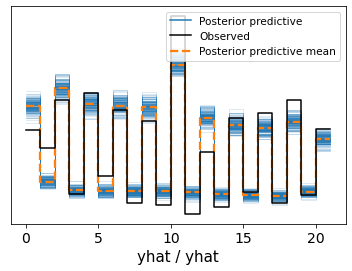

In [10]:
az.plot_ppc(az_ptn_exp1, num_pp_samples=200)

In [11]:
az_ptn_exp1.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.1131223 , 0.31577422, 0.57110348]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

### Model comparison

In [18]:
az.compare({"bs": az_bs_exp1, "ptn":az_ptn_exp1})

/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ptn,0,-12256.001947,437.854747,0.000000,0.968462,91.734328,0.000000,True,log
bs,1,-15275.684925,1555.376915,3019.682978,0.031538,68.897604,84.603172,True,log


## Experiment 2 - Bayesian Sampler

In [35]:
res_bs_exp2 = fit_svi(
    bs_complex_mlm_trial_level, 
    X_exp2, 
    y_exp2,
    optimizer = Adam(1e-3),
    n_steps = 10_000,
    full_rank=True,
    filename="local/svi-bs_complex_mlm_trial_level-exp2.p"
)

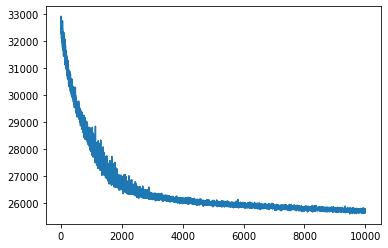

In [36]:
from matplotlib import pyplot as plt
plt.plot(res_bs_exp2["losses"])

In [37]:
az_bs_exp2 = arviz_from_svi(
    bs_complex_mlm_trial_level, 
    res_bs_exp2["guide"], 
    res_bs_exp2["params"], 
    X_exp2, 
    obs_data=y_exp2,
    filename = "local/az-bs_complex_mlm_trial_level-exp2svi.p"
)

<AxesSubplot:xlabel='yhat / yhat'>

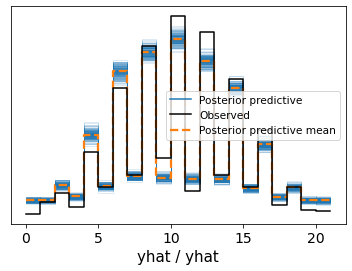

In [13]:
az.plot_ppc(az_bs_exp2, num_pp_samples=200)

In [21]:
az_bs_exp2.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.25145303, 0.1949195 , 0.55362746]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

## PTN - Experiment 2

In [41]:
res_ptn_exp2 = fit_svi(
    ptn_simplecond_mlm_trial_level_disc, 
    X_exp2, 
    y_exp2,
    optimizer = Adam(1e-3),
    n_steps = 10_000,
    full_rank=True,
    filename="local/svi-ptn_simplecond_mlm_trial_level_disc-exp2.p"
)

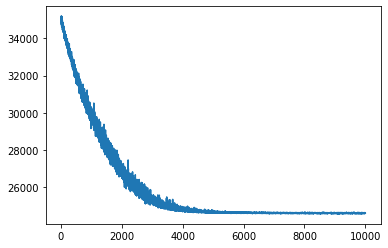

In [42]:
plt.plot(res_ptn_exp2["losses"])

In [44]:
az_ptn_exp2 = arviz_from_svi(
    ptn_simplecond_mlm_trial_level_disc, 
    res_ptn_exp2["guide"], 
    res_ptn_exp2["params"], 
    X_exp2, 
    obs_data=y_exp2,
    filename = "local/az-ptn_simplecond_mlm_trial_level_disc-exp2svi.p"
)

<AxesSubplot:xlabel='yhat / yhat'>

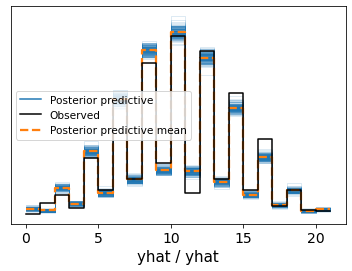

In [17]:
az.plot_ppc(az_ptn_exp2, num_pp_samples=200)

In [22]:
az_ptn_exp2.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.03806518, 0.37668837, 0.58524645]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

In [18]:
# az.loo(az_bs_exp2)
# az.loo(az_ptn_exp2)
az.compare({"bs": az_bs_exp2, "ptn":az_ptn_exp2})

/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ptn,0,-24032.241896,569.115040,0.000000,0.91618,92.294169,0.000000,True,log
bs,1,-25296.014723,1170.350022,1263.772827,0.08382,101.580937,56.817489,True,log


# Model inspection

Some questions to investigate:

- In PT+N model: 
    - What proportion of responses are contaminants? 
        - (11% and 4% in exp 1, exp 2 - seem reasonable)
    - What are estimates of $k$? What are estimates of $d$ and $d'$? Are they in line with the avg-level estimates? with the theory? 
        - (as before, which in exp2 is too high per theory)
    - Are subject-level $k$ and $d$ correlated? BS says they should be 
        - (maybe in exp 1, no in exp 2)
    - Could refit another version allowing $k$ to vary between conj/disj trials and "normal" trials. <-- __do this__
- In BS model: 
    - what proportion of responses are contaminants? 
        - (47% and 25% in exp 1, exp2 --- far too high to be realisic)
    - What are estimtes of beta? What are estimates of N? Are they reasonable? 
        - (seem reasonable)
    - Are subject-level beta and N correlated? BS says they shouldn't be, would likely be a sign of misfit 
        - (they are not)

### PT+N

__What are estimtes for $d$?__ At population-level, they are similar to prior estimates with averaged data. Per the theory's authors, they are higher than should be expected.

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

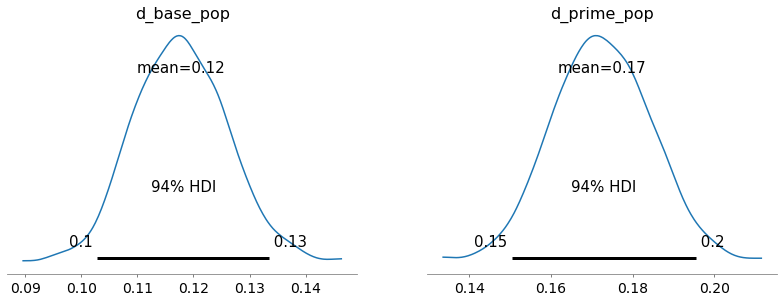

In [23]:
az_ptn_exp1.posterior["d_prime_pop"] = az_ptn_exp1.posterior.d_base_pop + np.exp(az_ptn_exp1.posterior.d_delta_pop)
az.plot_posterior(az_ptn_exp1, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)

# az.plot_forest(data=az_ptn_exp1, var_names=["d_subj"], combined=True)

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

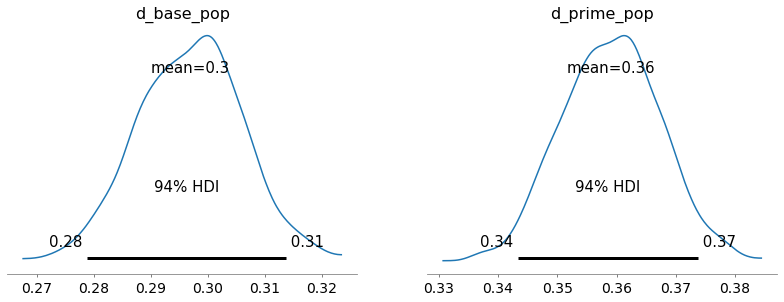

In [27]:
az_ptn_exp2.posterior["d_prime_pop"] = az_ptn_exp2.posterior.d_base_pop + np.exp(az_ptn_exp2.posterior.d_delta_pop)
az.plot_posterior(az_ptn_exp2, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)

In [94]:
# az.plot_forest(data=az_ptn_exp2, var_names=["k"], combined=True)

posterior_ptn2 = posterior_to_df_mlm(
    az_ptn_exp2, 
    ["d_base_pop","d_delta_pop","d_base_sd","d_delta_sd"],
    ["d_base_r", "d_delta_r", "d_subj", "d_prime_subj", "k"]
)

__Are $d$ and $k$ correlated?__ Negatively in experiment 1, no in experiment 2. The Experiment 1 findings are sort of Bayesian-sampler-esque but they are driven by just 3 extreme points each with a lot of uncertainty, so I don't think we should put much weight on them. Experiment 2 resuls are contrary to what bayesian sampler theory would predict.

Per the plots below, estimates of $k$ fall between about 3 and 30 for experiment 2. Seems roughly plausible psychologically? But for experiment 1 there are some exreme outliers with very large $k$ values.

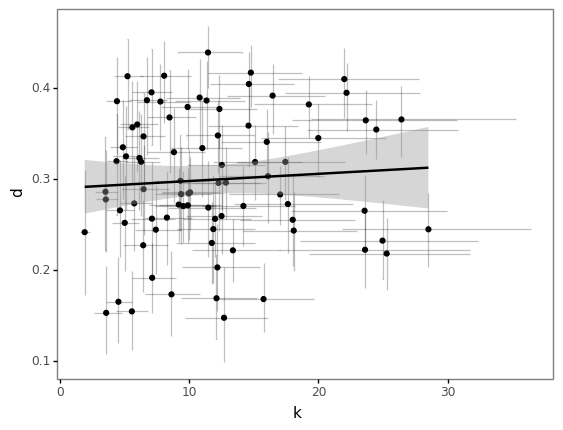

<ggplot: (-9223369091333953995)>

In [95]:
(
    posterior_ptn2 >>
    s.group_by(_.ID) >>
    s.summarize(
        k_est = _.k.mean(),
        k_ll = _.k.quantile(.05),
        k_ul = _.k.quantile(.95),
        d_est = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.05),
        d_ul = _.d_subj.quantile(.95)
    ) >>
    s.filter(_.k_est < 200.) >>
    ggplot(aes(x="k_est", y="d_est")) +
    geom_point() +
    geom_errorbar(aes(ymin="d_ll", ymax="d_ul"), width=0., alpha=.25) +
    geom_errorbarh(aes(xmin="k_ll", xmax="k_ul"), height=0, alpha=.25) +
    geom_smooth(method="lm") +
    labs(y="d", x="k") +
    theme_bw() +
    theme(panel_grid = element_blank())
)

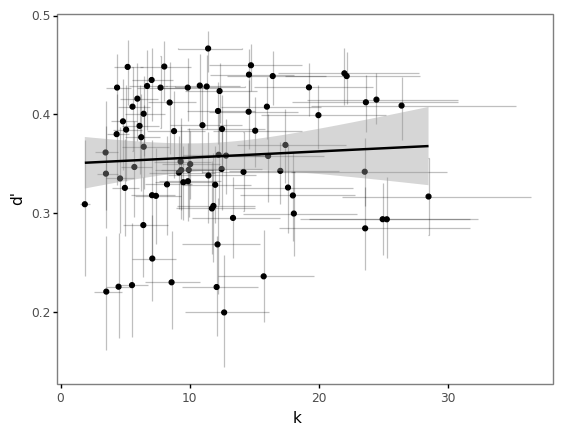

<ggplot: (2945520852309)>

In [96]:
(
    posterior_ptn2 >>
    s.group_by(_.ID) >>
    s.summarize(
        k_est = _.k.mean(),
        k_ll = _.k.quantile(.05),
        k_ul = _.k.quantile(.95),
        d_est = _.d_prime_subj.mean(),
        d_ll = _.d_prime_subj.quantile(.05),
        d_ul = _.d_prime_subj.quantile(.95)
    ) >>
    s.filter(_.k_est < 200.) >>
    ggplot(aes(x="k_est", y="d_est")) +
    geom_point() +
    geom_errorbar(aes(ymin="d_ll", ymax="d_ul"), width=0., alpha=.25) +
    geom_errorbarh(aes(xmin="k_ll", xmax="k_ul"), height=0, alpha=.25) +
    geom_smooth(method="lm") +
    labs(y="d'", x="k") +
    theme_bw() +
    theme(panel_grid = element_blank())
)

### BS model inspection

In [97]:
posterior_bs2 = posterior_to_df_mlm(
    az_bs_exp2, 
    ["N_prime_pop","N_delta_pop","N_prime_sd","N_delta_sd", "beta_pop", "beta_sd"],
    ["N_prime_r", "N_delta_r", "N_subj", "N_prime_subj", "beta_subj"]
)

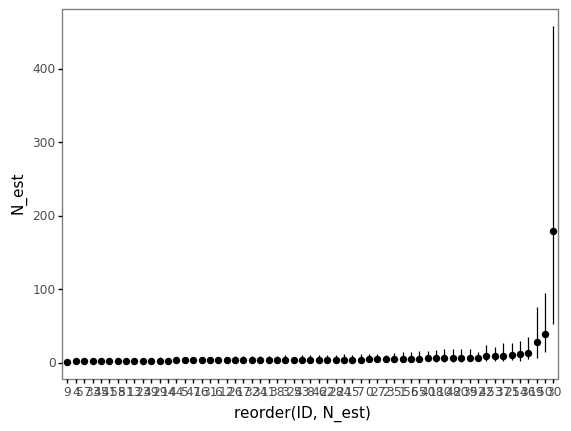

<ggplot: (-9223369091334051142)>

In [98]:
(
    posterior_bs2 >>
    s.group_by(_.ID) >>
    s.summarize(
        N_est = _.N_subj.mean(),
        N_ll = _.N_subj.quantile(.05),
        N_ul = _.N_subj.quantile(.95),
        beta_est = _.beta_subj.mean(),
        beta_ll = _.beta_subj.quantile(.05),
        beta_ul = _.beta_subj.quantile(.95)
    ) >>
    ggplot(aes(x="reorder(ID, N_est)", y="N_est", ymin="N_ll", ymax="N_ul")) +
    geom_pointrange() +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

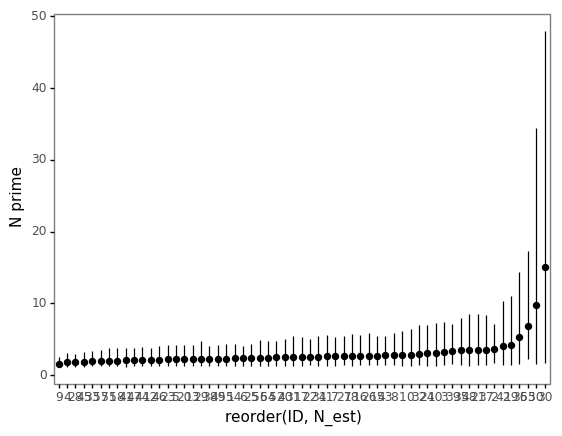

<ggplot: (-9223369091334351868)>

In [99]:
(
    posterior_bs2 >>
    s.group_by(_.ID) >>
    s.summarize(
        N_est = _.N_prime_subj.mean(),
        N_ll = _.N_prime_subj.quantile(.05),
        N_ul = _.N_prime_subj.quantile(.95),
        beta_est = _.beta_subj.mean(),
        beta_ll = _.beta_subj.quantile(.05),
        beta_ul = _.beta_subj.quantile(.95)
    ) >>
    ggplot(aes(x="reorder(ID, N_est)", y="N_est", ymin="N_ll", ymax="N_ul")) +
    geom_pointrange() +
    labs(y="N prime") +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

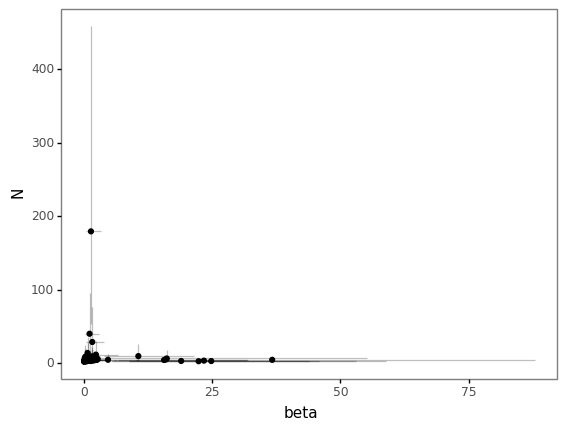

<ggplot: (2945520887574)>

In [100]:
(
    posterior_bs2 >>
    s.group_by(_.ID) >>
    s.summarize(
        N_est = _.N_subj.mean(),
        N_ll = _.N_subj.quantile(.05),
        N_ul = _.N_subj.quantile(.95),
        beta_est = _.beta_subj.mean(),
        beta_ll = _.beta_subj.quantile(.05),
        beta_ul = _.beta_subj.quantile(.95)
    ) >>
    ggplot(aes(x="beta_est", y="N_est")) +
    geom_point() +
    geom_errorbar(aes(ymin="N_ll", ymax="N_ul"), width=0., alpha=.25) +
    geom_errorbarh(aes(xmin="beta_ll", xmax="beta_ul"), height=0., alpha=.25) +
#     geom_smooth(method="lm") +
    labs(y="N", x="beta") +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

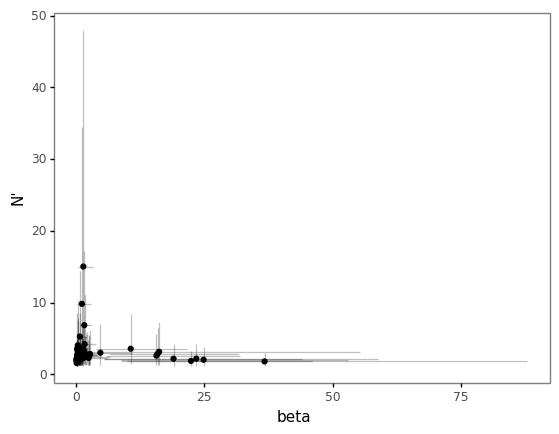

<ggplot: (2945521399444)>

In [101]:
(
    posterior_bs2 >>
    s.group_by(_.ID) >>
    s.summarize(
        N_est = _.N_prime_subj.mean(),
        N_ll = _.N_prime_subj.quantile(.05),
        N_ul = _.N_prime_subj.quantile(.95),
        beta_est = _.beta_subj.mean(),
        beta_ll = _.beta_subj.quantile(.05),
        beta_ul = _.beta_subj.quantile(.95)
    ) >>
    ggplot(aes(x="beta_est", y="N_est")) +
    geom_point() +
    geom_errorbar(aes(ymin="N_ll", ymax="N_ul"), width=0., alpha=.25) +
    geom_errorbarh(aes(xmin="beta_ll", xmax="beta_ul"), height=0., alpha=.25) +
#     geom_smooth(method="lm") +
    labs(y="N'", x="beta") +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)